# Notebook de modélisation
## Adrian Rodriguez
## Projet 5 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [1]:
import pandas as pd
pd.options.display.max_columns = None

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("default")
import pyLDAvis.sklearn
from IPython.display import Image

from functions import *

import time
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
start_notebook = time.time()

---
# 1. Importation et exploration préliminaire


In [3]:
cleaned_questions_raw = pd.read_csv('src/cleaned_questions.csv')

In [4]:
cleaned_questions_raw.head()

,Id,Tags,Title_Body,Cleaned_Title_Body
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...


In [5]:
cleaned_questions_raw.shape

(49131, 4)

In [6]:
cleaned_questions_raw.columns

Index(['Id', 'Tags', 'Title_Body', 'Cleaned_Title_Body'], dtype='object')

In [7]:
cleaned_questions_raw.isna().sum()

Id                    0
Tags                  1
Title_Body            0
Cleaned_Title_Body    0
dtype: int64

In [8]:
cleaned_questions_raw[cleaned_questions_raw.Tags.isna()]

,Id,Tags,Title_Body,Cleaned_Title_Body
44699,31246192,NaN,How to check for NaN in golang <p>How can I ch...,check nan check float variable nan e.g.


In [9]:
# Le tag s'appelle 'nan'. A l'importation, pandas la reconnu comme NaN
cleaned_questions_raw.Tags = cleaned_questions_raw.Tags.fillna('nan')
cleaned_questions_raw[cleaned_questions_raw.Id == 31246192]

,Id,Tags,Title_Body,Cleaned_Title_Body
44699,31246192,nan,How to check for NaN in golang <p>How can I ch...,check nan check float variable nan e.g.


In [10]:
cleaned_questions_raw.isna().sum()

Id                    0
Tags                  0
Title_Body            0
Cleaned_Title_Body    0
dtype: int64

In [11]:
cleaned_questions = cleaned_questions_raw.copy()
cleaned_questions.shape

(49131, 4)

---
# 2. Classification non supervisée avec LDA
Méthode : 
- 1/ Création du vecteur de mots
- 2/ Calcul du nombre de sujet idéal
- 3/ Formation du modèle
- 4/ Vérification des résultats

## 2-1. Création du vecteur de mots

In [12]:
corpus = cleaned_questions.Cleaned_Title_Body

In [13]:
count_vectorizer = CountVectorizer()
feature_matrix = count_vectorizer.fit_transform(corpus)
display(feature_matrix.shape)

(49131, 55570)

In [14]:
# Sauvegarde du vectoizer
pickle.dump(count_vectorizer, open('api/src/count_vectorizer.sav', 'wb'))

## 2-2. Détermination du nombre de sujet idéal

In [15]:
results = pd.DataFrame()
tmp_result = pd.DataFrame(index = range(1))
for i in np.arange(5, 70, 5):
    print(f'{i} composants en cours de traitement...')
    lda_model = LatentDirichletAllocation(n_components=i, random_state=123, n_jobs=-1)

    lda_model.fit_transform(feature_matrix)

    tmp_result['n_components'] = i
    tmp_result['log_likelihood'] = lda_model.score(feature_matrix)
    tmp_result['perplexity'] = lda_model.perplexity(feature_matrix)

    results = results.append(tmp_result)

results

5 composants en cours de traitement...
10 composants en cours de traitement...
15 composants en cours de traitement...
20 composants en cours de traitement...
25 composants en cours de traitement...
30 composants en cours de traitement...
35 composants en cours de traitement...
40 composants en cours de traitement...
45 composants en cours de traitement...
50 composants en cours de traitement...
55 composants en cours de traitement...
60 composants en cours de traitement...
65 composants en cours de traitement...


,n_components,log_likelihood,perplexity
0,5,-1.250154e+07,1815.576153
0,10,-1.247089e+07,1782.469587
0,15,-1.236885e+07,1676.576853
0,20,-1.233560e+07,1643.447064
0,25,-1.232036e+07,1628.473078
0,30,-1.232279e+07,1630.852898
0,35,-1.233484e+07,1642.689419
0,40,-1.233976e+07,1647.550533
0,45,-1.233867e+07,1646.472786
0,50,-1.237377e+07,1681.533171


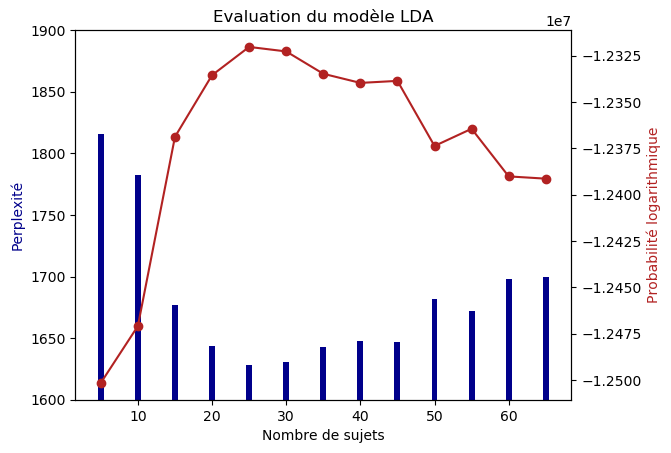

In [16]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(results.n_components,
        results.perplexity,
        color='darkblue')
ax2.plot(results.n_components,
         results.log_likelihood,
         'o-',
         color="firebrick")
min_y = int(results.perplexity.min()/100)*100
max_y = int((results.perplexity.max()+100)/100)*100
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('Nombre de sujets')
ax1.set_ylabel('Perplexité', color='darkblue')
ax2.set_ylabel('Probabilité logarithmique', color='firebrick')
plt.title('Evaluation du modèle LDA')
plt.savefig('img/img_LDA_evaluation.png',
            transparent=True)
plt.show()

Je cherche à avoir la probabilité logarithmique la plus élevée et une moindre perplexité.

## 2-3. Formation du modèle

In [17]:
min_perp = results.perplexity.min()
n_comp = results[results.perplexity == min_perp].n_components.item()
print(f'Le nombre de sujet idéal est de {n_comp}')
# Je forme le modèle
lda = LatentDirichletAllocation(n_components=n_comp, random_state=123, n_jobs=-1)
%time lda_out = lda.fit_transform(feature_matrix)

Le nombre de sujet idéal est de 25
Wall time: 1min 45s


In [18]:
# Sauvegarde du modèle
pickle.dump(lda, open('api/src/unsupervised_model.sav', 'wb'))

In [19]:
# Sujet dominants dans chaque documents
doc_topic = get_doc_topic(lda, corpus, lda_out)
doc_topic

,Topic_#0,Topic_#1,Topic_#2,Topic_#3,Topic_#4,Topic_#5,Topic_#6,Topic_#7,Topic_#8,Topic_#9,Topic_#10,Topic_#11,Topic_#12,Topic_#13,Topic_#14,Topic_#15,Topic_#16,Topic_#17,Topic_#18,Topic_#19,Topic_#20,Topic_#21,Topic_#22,Topic_#23,Topic_#24
0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.11,0.58,0.00,0.00,0.00,0.0,0.27,0.0,0.0,0.00,0.00
1,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.13,0.00,0.82,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00
2,0.0,0.00,0.00,0.00,0.0,0.00,0.24,0.0,0.40,0.00,0.0,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.20
3,0.0,0.00,0.00,0.00,0.0,0.56,0.00,0.0,0.00,0.19,0.0,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00
4,0.0,0.00,0.02,0.00,0.0,0.00,0.00,0.0,0.29,0.00,0.0,0.00,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49126,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.40,0.17,0.0,0.27,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.0,0.0,0.09,0.00
49127,0.0,0.00,0.00,0.72,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.0,0.00,0.0,0.0,0.02,0.02
49128,0.0,0.04,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.09,0.00,0.00,0.07,0.00,0.75,0.0,0.03,0.0,0.0,0.00,0.00
49129,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.18,0.00,0.0,0.00,0.30,0.00,0.16,0.00,0.00,0.33,0.00,0.0,0.00,0.0,0.0,0.00,0.00


<Figure size 640x480 with 0 Axes>

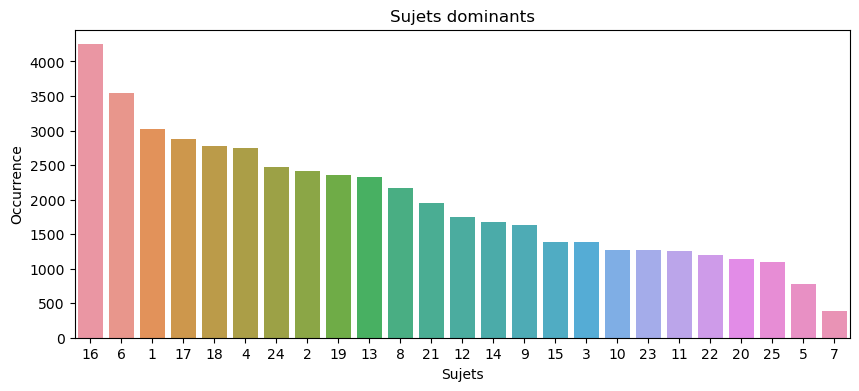

In [20]:
dominant_topic = doc_topic.copy()
dominant_topic['dominant_topic'] = np.argmax(dominant_topic.values, axis=1) + 1
order = dominant_topic.groupby('dominant_topic')['Topic_#1'].count().sort_values(ascending=False).index

plt.clf()
plt.figure(figsize=(10,4))
sns.countplot(dominant_topic.dominant_topic, order=order)
plt.title('Sujets dominants')
plt.xlabel('Sujets')
plt.ylabel('Occurrence')
plt.savefig('img/img_dominant_topic.png',
            transparent=True)

In [21]:
# Top mots clés des différents sujets.
topic_keywords = show_topics(count_vectorizer, lda, 5)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic_#' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.to_csv('api/src/topic_keyword.csv')
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic_#0,component,react,element,angular,state
Topic_#1,docker,command,container,image,variable
Topic_#2,time,memory,date,java,stream
Topic_#3,view,screen,image,app,layout
Topic_#4,swift,message,controller,view,bar
Topic_#5,string,function,code,value,return
Topic_#6,document,tab,query,group,mongodb
Topic_#7,net,core,server,package,asp
Topic_#8,xcode,ios,version,app,build
Topic_#9,difference,thread,code,task,pointer


In [22]:
panel = pyLDAvis.sklearn.prepare(lda, feature_matrix, count_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'img/lda.html')
pyLDAvis.display(panel)

## 2.4 Vérification des résultats
A partir des sujets dominants dans chaque documents et des 5 mots clés principaux de chaque sujets dominants, je constitue une suggestion de tags non supervisée.

In [23]:
pred_tag = get_unsupervised_tag(doc_topic, df_topic_keywords, corpus)
cleaned_questions = pd.merge(cleaned_questions, pred_tag, left_index=True, right_index=True)
col = ['Cleaned_Title_Body', 'Tags', 'unsupervised_tag']
cleaned_questions[col].head(20)

,Id,Tags,Title_Body,Cleaned_Title_Body,unsupervised_tag
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...,"key,type,object,array,class"
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...,"datum,type,object,array,value"
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...,"document,xcode,ios,error,column"
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...,"string,function,code,difference,error"
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...,"xcode,ios,android,studio,project"
...,...,...,...,...,...
49126,29895387,"ios,service_worker,progressive_web_apps",Service workers and iOS / Safari <p>On Chromiu...,service worker ios safari chromium page servic...,"xcode,ios,difference,error,service"
49127,29894997,"javascript,jquery,html,ios,css",Prevent iOS bounce without disabling scroll ab...,ios bounce scroll ability solution ios bounce ...,"view,screen,image,app,text"
49128,29894781,javascript,Javascript selected text highlighting prob <p>...,javascript select text html page text content ...,"text,list,color,line,code"
49129,29894749,"ios,permissions",Complete list of iOS app permissions <p>Differ...,complete list ios permission different web sit...,"xcode,android,studio,request,api"


---
# 3.Classification supervisée
## 3-1. Vectorisation des données textuelles

In [24]:
corpus = cleaned_questions.Cleaned_Title_Body
# Vectorisation des données
tfidf_vectorizer = TfidfVectorizer()
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_matrix.shape

(49131, 55570)

In [25]:
tfidf_feature_matrix

<49131x55570 sparse matrix of type '<class 'numpy.float64'>'
	with 1125335 stored elements in Compressed Sparse Row format>

In [26]:
# Vectorisation des targets
mlb = MultiLabelBinarizer()
target = cleaned_questions.Tags
target = [set(i.split(',')) for i in target]
target = mlb.fit_transform(target)
target.shape

(49131, 967)

In [27]:
# Sauvegarde du vectoizer
pickle.dump(tfidf_vectorizer, open('api/src/tfidf_vectorizer.sav', 'wb'))
# Sauvegarde du binarizer
pickle.dump(mlb, open('api/src/binarizer.sav', 'wb'))

## 3-2. Recherche du meilleur classifieur
La comparaison entre modèle s'effectuera avec le score de Jaccard

In [28]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_feature_matrix, target, test_size=0.2, random_state=123)

LogisticRegression en cours d'exécution...
LinearSVC en cours d'exécution...
SGD en cours d'exécution...
Wall time: 1h 41min 29s


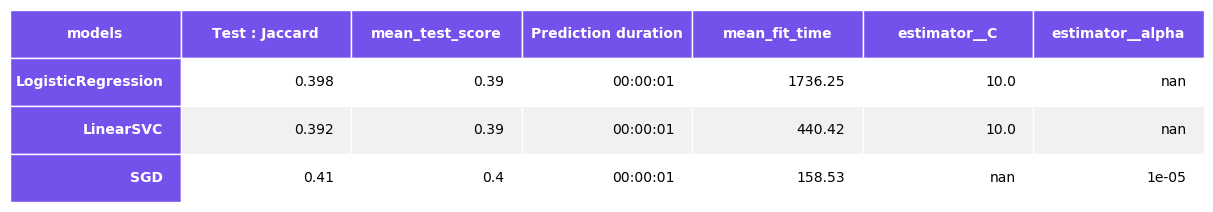

In [29]:
classifiers = [('LogisticRegression',
                LogisticRegression(penalty='l1', solver='liblinear'),
                [{'estimator__C': [1, 10]}]),

              ('LinearSVC',
               LinearSVC(penalty='l1', dual=False),
               [{'estimator__C': [1, 10]}]), 

              ('SGD',
               SGDClassifier(penalty='l1'),
               [{'estimator__alpha': [10**-6, 10**-5, 10**-4]}])]

%time evaluate_classifier(X_train, X_test, y_train, y_test, classifiers, cv=3)

Pour des raisons de temps de calcul des RandomForest et GradientBoosting à 50k questions, ces 2 derniers n'ont pas été intégré dans GridSearchCV. 

Cependant, le tableau ci-dessous montrent les résultats pour un échantillon réduit à 10k questions, avec RandomForest et GradientBoosting.   
Le premier montre un temps de prédiction très élevé, il n'est pas adapaté pour une mise en production sur ce projet.   
Pour le second, le temps d'entrainement est élevé à 10k questions. Les coûts de maintenance seraient donc non négligeable en cas de mise en production.   
Les autres algorithmes ont un score de Jaccard équivalent pour de bien meilleurs temps d'entrainement et de prédiction.

Note concernant les méthodes ensemblistes :     
L'évaluation des classifieurs avec les méthodes ensemblistes sur 10000 questions dure plus de 7h. Des tests ont été réalisés avec 50000 questions, mais la configuration machine n'est pas adaptée. Les notebooks en ligne comme Google Colab coupe les scripts au bout de 12h. L'utilisation d'un GPU en ligne n'est pas possible sur ce notebook, car réservé à des bibliothèques comme Tensorflow, Keras.

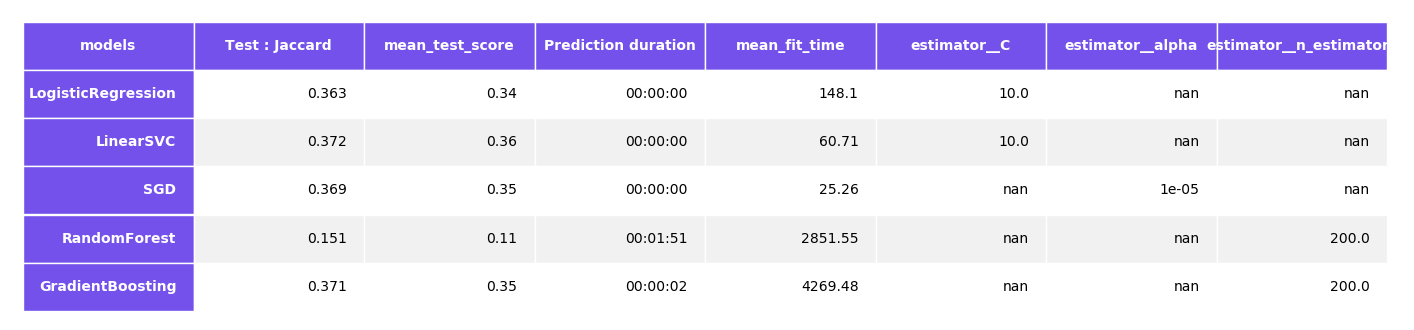

In [30]:
Image('img/img_results_models_10k.PNG')

Wall time: 47min 53s
Wall time: 723 ms


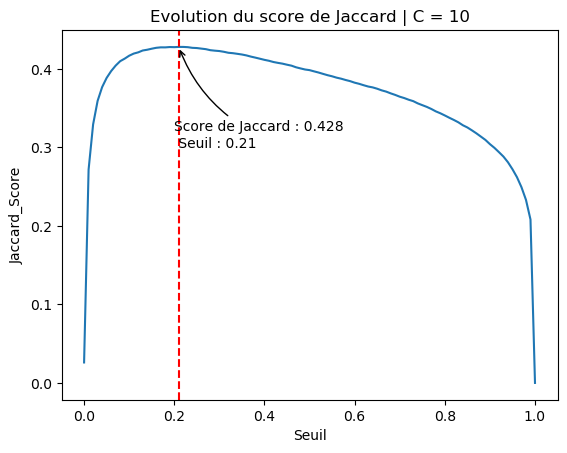

Wall time: 2min 38s
Wall time: 745 ms


<Figure size 640x480 with 0 Axes>

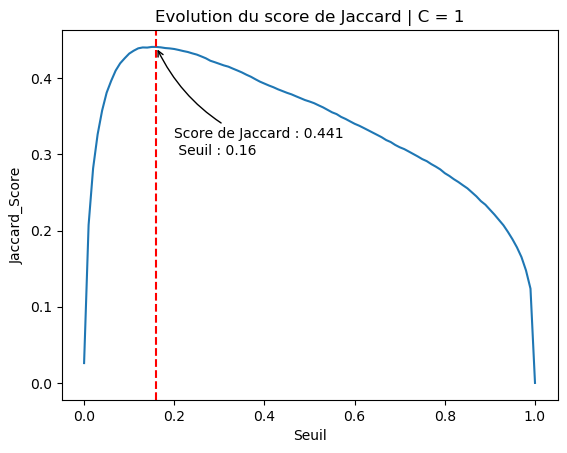

<Figure size 640x480 with 0 Axes>

In [31]:
# Recherche du meilleur seuil de la régression logistique
for c in [10, 1]:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    model = OneVsRestClassifier(model)
    %time model.fit(X_train, y_train)
    %time y_pred = model.predict_proba(X_test)

    tresh = {}
    for i in np.arange(0, 1.01, 0.01):
        y_pred_tres = pd.DataFrame(y_pred).applymap(lambda x: 1 if x > i else 0)
        tresh[i] = jaccard_score(y_test, y_pred_tres, average='weighted')
    
    df_tresh = pd.DataFrame.from_dict(tresh, orient='index').reset_index()
    df_tresh = df_tresh.rename(columns={'index': 'Seuil', 0: 'Jaccard_Score'})
    best_tresh = df_tresh.sort_values(by='Jaccard_Score', ascending=False).iloc[0].Seuil
    best_jacc = df_tresh.sort_values(by='Jaccard_Score', ascending=False).iloc[0].Jaccard_Score

    fig, ax = plt.subplots()
    sns.lineplot(x='Seuil', y='Jaccard_Score', data=df_tresh)
    ax.axvline(x=best_tresh, linestyle='--', color='red')
    text = 'Score de Jaccard : ' + str(round(best_jacc,3)) + '\n Seuil : ' + str(best_tresh)
    ax.annotate(text, xy=(best_tresh, best_jacc), xytext=(0.2, 0.3),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'))
    plt.title('Evolution du score de Jaccard | C = ' + str(c))
    plt.savefig('img/img_evolution_jaccard_C' + str(c) + '.png',
                transparent=True)
    plt.show()
    plt.clf()

In [32]:
# Sauvegarde du modèle
pickle.dump(model, open('api/src/supervised_model.sav', 'wb'))

## 3-3. Vérification

In [38]:
y_pred_tres = pd.DataFrame(y_pred).applymap(lambda x: 1 if x > best_tresh else 0)

# Je convertis le dataframe en array
y_pred_tres = y_pred_tres.to_numpy()

# Je récupère les nom des tags prédits, les tags originaux ainsi que les textes nettoyés originaux
sup_pred = transform_tuple(mlb.inverse_transform(y_pred_tres))
tag = transform_tuple(mlb.inverse_transform(y_test))
text = transform_tuple(tfidf_vectorizer.inverse_transform(X_test))

# J'assemble le tout dans un dataframe pour une meilleure comparaison
df_text = pd.DataFrame(text, columns=['original_text_cleaned']).original_text_cleaned.str.replace(',', ' ')
df_tag = pd.DataFrame(tag, columns=['original_tags'])
df_sup_pred = pd.DataFrame(sup_pred, columns=['supervised_pred'])

results_tmp = pd.merge(df_text, df_tag, left_index=True, right_index=True)
results = pd.merge(results_tmp, df_sup_pred, left_index=True, right_index=True)
results.head(20)

,original_text_cleaned,original_tags,supervised_pred
0,messageall prop unit property component well r...,"jasmine,reactjs,unit_testing","javascript,reactjs,unit_testing"
1,imodelfilter jsonignore webapi2 recommend swas...,"asp.net_web_api,c#,swagger",
2,fishy affected uiswitch kcfrunloopcommonmode u...,xcode11,
3,ngforof company ts property get final componen...,"angular,angular2_template",angular
4,github repository android studio project want,"android,android_studio,git","android,android_studio,android_studio_3.0,git,..."
5,when script wrong tell function suggest necess...,node.js,"javascript,python"
6,kube kubernetes cluster kubectl kubernete azur...,"azure,kubernetes","azure,google_kubernetes_engine,kubectl,kubernetes"
7,tsconfig doc typescript child directory setup ...,typescript,typescript
8,getintentsender cancelall notificationmanagerc...,"android,android_notifications",android
9,play_arrow sharedinstance inforation sender fa...,"crashlytics,firebase,firebase_console,swift","crashlytics,firebase,ios,swift,xcode"


In [51]:
unpredict = round(len(results[results.supervised_pred == '']) / len(results) * 100, 2)
print(f"Le taux de non prédiction sur la modélisation non supervisée s'élève à " + str(unpredict) + " %, sur l'échantillon de test, soit 10 000 questions.")

Le taux de non prédiction sur la modélisation non supervisée s'élève à 7.74 %, sur l'échantillon de test, soit 10 000 questions.


## 3-4. Tags les moins performants

In [56]:
# Récurrence des tags sur l'échantillon de test
tags = results.original_tags.str.split(',').explode().reset_index()
tags = tags.groupby('original_tags').count().sort_values(by='index', ascending=False).reset_index().rename(columns={'index': 'recurrence'})
tags

,original_tags,recurrence
0,javascript,1037
1,android,1031
2,python,1026
3,java,702
4,angular,579
...,...,...
958,formatting,1
959,emoji,1
960,resttemplate,1
961,properties,1


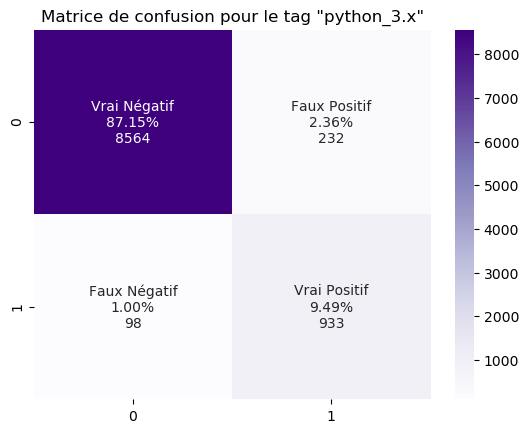

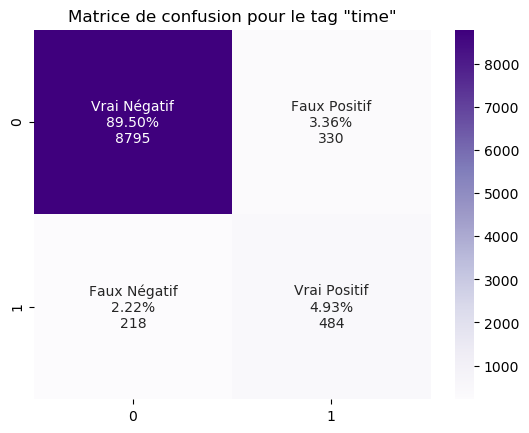

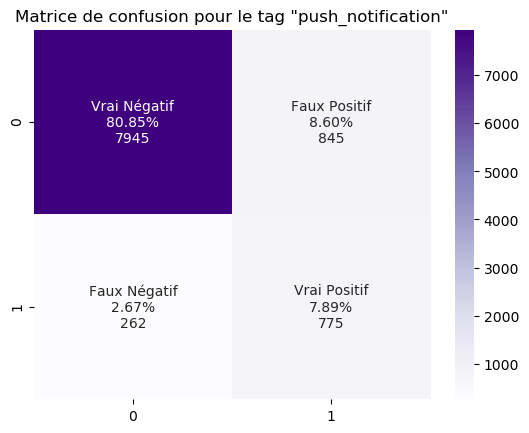

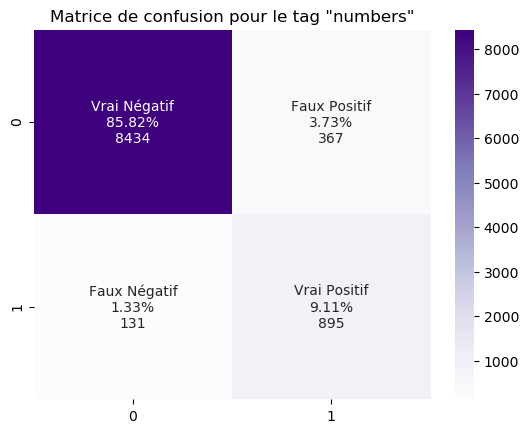

<Figure size 640x480 with 0 Axes>

In [62]:
# Recherche des tags les moins performants (vrais négatif inférieur à 90 %)
from sklearn.metrics import confusion_matrix

for i in range(len(tags)):
    n_tag = i
    cf_matrix = confusion_matrix(y_test[:, n_tag], y_pred_tres[:, n_tag])
    if cf_matrix[0][0] < 9000:
        # cf_matrix = np.array([[9000, 0], [0, 0]])

        name = ['Vrai Négatif', 'Faux Positif', 'Faux Négatif', 'Vrai Positif']
        percent = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(name, percent, counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')
        loc = np.where(mlb.classes_ == tags.original_tags[n_tag])

        plt.title('Matrice de confusion pour le tag "' + mlb.classes_[loc][0] + '"')
        plt.savefig('img/img_matrice_confusion_' + mlb.classes_[loc][0] + '.png',
                    transparent=True)

        plt.show()
        plt.clf()

Le tag le moins performant est push_notifications

In [63]:
end_notebook = time.time()
exec_time(start_notebook, end_notebook)

'05:29:42'

# 4. Version des packages

In [64]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("Numpy", numpy.__version__)
import pandas; print("Pandas", pandas.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import requests; print("requests", requests.__version__)
import bs4; print("BeautifulSoup", bs4.__version__)
import re; print("re", re.__version__)
import spacy; print("spacy", spacy.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy 1.19.1
Pandas 1.0.3
Seaborn 0.10.0
Matplotlib 3.1.3
requests 2.24.0
BeautifulSoup 4.8.2
re 2.2.1
spacy 2.3.2
